In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import ARIMA
from statsmodels.stats.api import het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [2]:
y = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01')

<Axes: xlabel='DATE'>

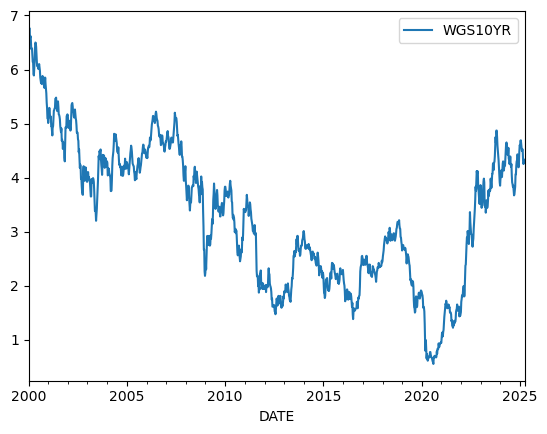

In [3]:
y.plot()

In [6]:
# спецификация модели
mod = ARIMA(y, order=(2,1,1), trend='n', missing='drop')
# подгонка модели на данных
res = mod.fit()
# выводим результаты подгонки
res.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                WGS10YR   No. Observations:                 1317
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1193.078
Date:                Tue, 01 Apr 2025   AIC                          -2378.156
Time:                        09:28:51   BIC                          -2357.427
Sample:                    01-07-2000   HQIC                         -2370.383
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1127      4.501      0.025      0.980      -8.709       8.934
ar.L2          0.0216      1.029      0.021      0.983      -1.995       2.038
ma.L1          0.1163      4.502      0.026      0.979      -8.707       8.939
sigma2         0.0095      0.000     32.163      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                82.51
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.00
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

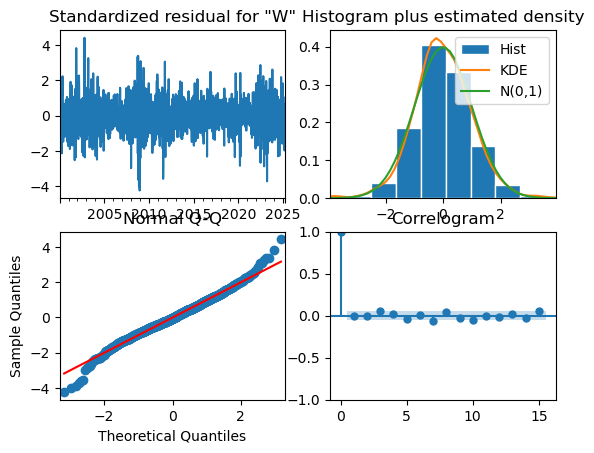

In [7]:
res.plot_diagnostics(lags=15)

plt.show()

In [8]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (-sigma2)
model_df = mod.k_params-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
acorr_ljungbox(res.resid[mod.k_diff:] , lags=[6], model_df=model_df)

,lb_stat,lb_pvalue
6,7.312524,0.062576


p-value больше 0.05 -- нет серийной корреляции

In [9]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (-sigma2)
model_df = mod.k_params-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
lm_stat, lm_pval, f_stat, f_pval = het_arch(res.resid[mod.k_diff:], nlags=6, ddof=model_df)

lm_stat, lm_pval

(np.float64(134.73848590605417), np.float64(1.2903097590593278e-26))

p-value меньше 0.05 -- есть гетероскедастичность. нас это не устраивает: мало лагов, не дифферинциировано, арима не работает

In [11]:
from scipy.stats import chi2

chi2.isf(0.05, df= 6 - model_df)

np.float64(7.814727903251178)